In [1]:
# Libraries for Visualization
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette('viridis')

# Parameters for the visualizations
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# For easy computation over certain datasets
import numpy as np
np.set_printoptions(suppress=True)

# Pyspark utilities
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as F

# Execution mode:
# Cluster = -1
# Local >= 1 (i.e., number of files to load)

EXEC_MODE = 1
cloud = False

# TODO
from lib import *

# start spark with 1 worker thread
sc = init()
sc.setLogLevel("ERROR")

# Start SparkSession to use DataFrames
spark = SparkSession(sc)

In [2]:
# Same as above, load a part of the table in memory and use it.
task_events = Table('task_events', sc, EXEC_MODE, cloud)

In [7]:
task_events.pprint(2)

,time,missing_info,job_id,task_index,machine_id,event_type,user,scheduling_class,priority,cpu_request,memory_request,disk_space_request,different_machines_restriction
0,5611824441,NA,6251812952,1761,1306108,4,fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=,0,2,0.02499,0.07959,0.0003862,1
1,5611824625,NA,6251974185,252,38676295,4,fJYeclskJqPWsAT6TX/r9X5OiIZpSEb2PBGliYAOMxM=,0,2,0.02499,0.03339,0.0003862,1


In [3]:
task_usage = Table('task_usage', sc, EXEC_MODE, cloud)

In [6]:
# Select first SUBMIT transition for each job & task
submit_status = task_events.select(['job_id', 'task_index', 'event_type', 'time'])\
    .filter(lambda x: x[2] in ['0'])\
    .map(lambda x: (x[0]+', '+x[1], float(x[3])))

rdd_submit = submit_status.reduceByKey(min)

# Select first OUT transition for each job & task
outpending_status = task_events.select(['job_id', 'task_index', 'event_type', 'time'])\
    .filter(lambda x: x[2] in ['1', '3', '5', '6'])\
    .map(lambda x: (x[0]+', '+x[1], float(x[3])))

rdd_out = outpending_status.reduceByKey(min)

# Join everything and compute delta time for each job & task
rdd_deltatimes = rdd_submit.join(rdd_out).map(lambda x: (x[0].split(', ')[0], x[1][1] - x[1][0]))

# Average of the delta times for each job
rdd_deltatimes = rdd_deltatimes.groupByKey().mapValues(lambda x: round(sum(x)/len(x), 3))

rdd_deltatimes.take(10)

[('6114773114', 0.0),
 ('6252020538', 2679777.22),
 ('6252024742', 838941.182),
 ('6251501988', 1414804.0),
 ('6252025974', 1649972.0),
 ('6252026716', 2163724.0),
 ('6252027974', 2179157.667),
 ('6176858948', 0.0),
 ('6252031834', 810525.5),
 ('4028922835', 0.0)]

In [7]:
# Load the task_constraints table
task_constraints = Table('task_constraints', sc, EXEC_MODE, cloud)

In [8]:
# Selects each occurence of constraint registered for each process
task_constraints_per_job = task_constraints.select(['job_id'])\
    .map(lambda x: (x[0],1))\
    .reduceByKey(lambda a,b: a+b)
task_constraints_per_job.take(5)


[('6231386586', 91),
 ('4923128384', 130),
 ('6124898063', 84),
 ('6238340468', 9222),
 ('515042969', 89610)]

In [9]:
# Join the delta time and the number of constraints in one RDD
rdd_delta_constraints = rdd_deltatimes.join(task_constraints_per_job).filter(lambda x: x[1][1] < 50)
rdd_delta_constraints.take(5)


[('6252131400', (1565666.0, 3)),
 ('6252169000', (1383446.0, 3)),
 ('6252205299', (1519569.0, 3)),
 ('6252169178', (1494732.0, 2)),
 ('6252244787', (3425247.0, 3))]

Text(0.5, 1.0, 'Time spent on PENDING state depending on the number of constraints')

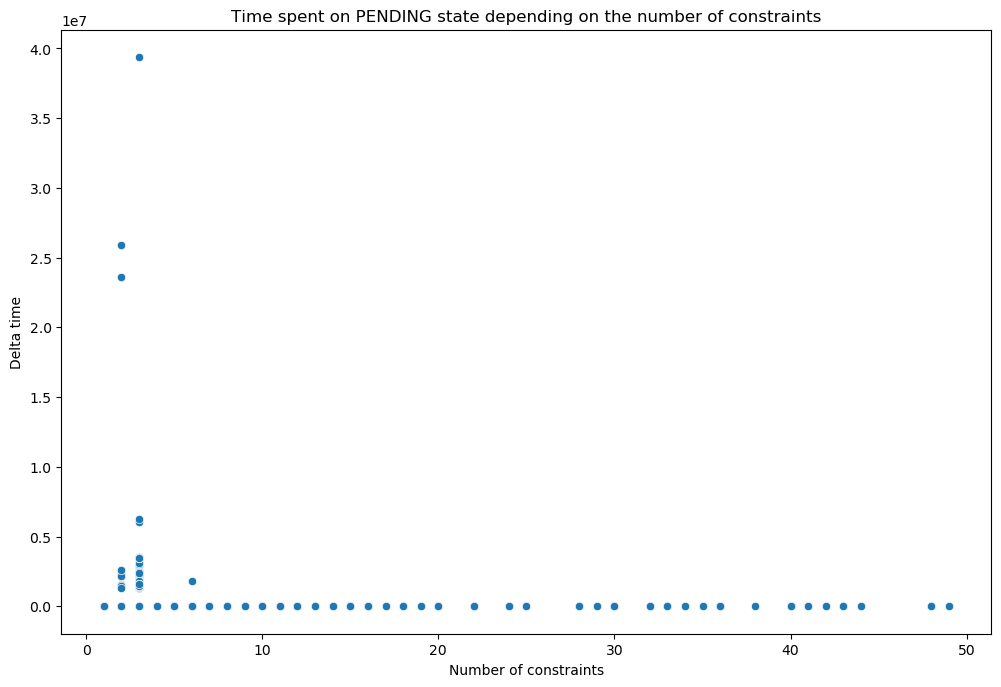

In [10]:
# Create the list of values from the last RDD
rdd_to_map = rdd_delta_constraints.collectAsMap()
deltatimes = [v[0] for v in rdd_to_map.values()]
constraints = [v[1] for v in rdd_to_map.values()]

# And then pass it to seaborn to create a barplot to have a global view
g = sns.scatterplot(x=constraints, y=deltatimes)

g.set_xlabel("Number of constraints")
g.set_ylabel("Delta time")

g.set_title("Time spent on PENDING state depending on the number of constraints")